In [99]:
# imports
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [100]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [101]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Yen Futures - Settle'}, xlabel='Date'>

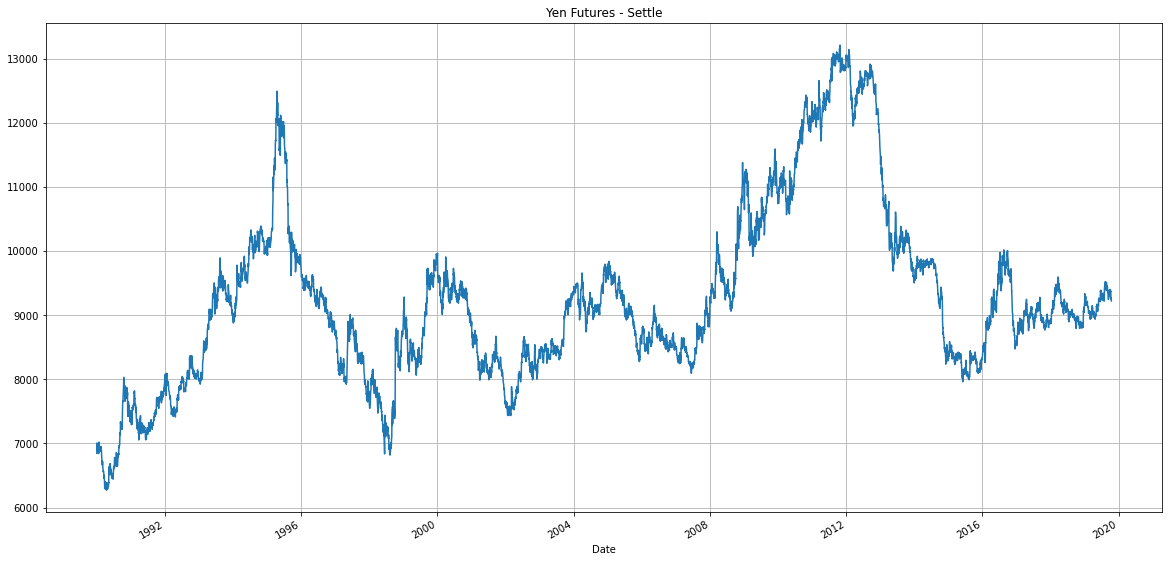

In [102]:
# Plot just the "Settle" column from the dataframe:
yen_futures['Settle'].plot(figsize=(20,10), title='Yen Futures - Settle', grid=True)

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [103]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])
settle_noise

Date
1990-01-02   -61.503967
1990-01-03   -21.799756
1990-01-04    98.942896
1990-01-05    40.776052
1990-01-08    49.689938
                ...    
2019-10-09    24.939247
2019-10-10    -5.868559
2019-10-11   -54.454594
2019-10-14   -36.423060
2019-10-15   -75.844123
Name: Settle_cycle, Length: 7515, dtype: float64

In [104]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_settle = yen_futures['Settle'].to_frame()
yen_settle['Noise'] = settle_noise
yen_settle['Trend'] = settle_trend
yen_settle.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:title={'center':'Settle Price vs. the Trend for 2015 to present'}, xlabel='Date'>

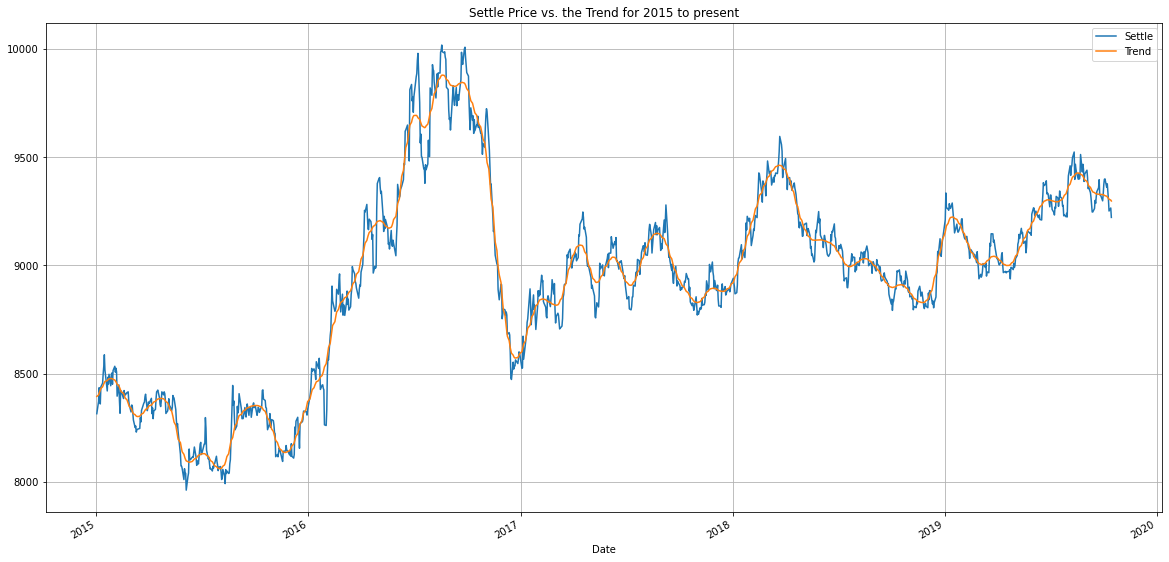

In [105]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yen_settle.loc['2015-01':, :].drop(columns=['Noise']).plot(figsize=(20,10),
                                                           title='Settle Price vs. the Trend for 2015 to present',
                                                          grid=True)

<AxesSubplot:title={'center':'Settle Noise'}, xlabel='Date'>

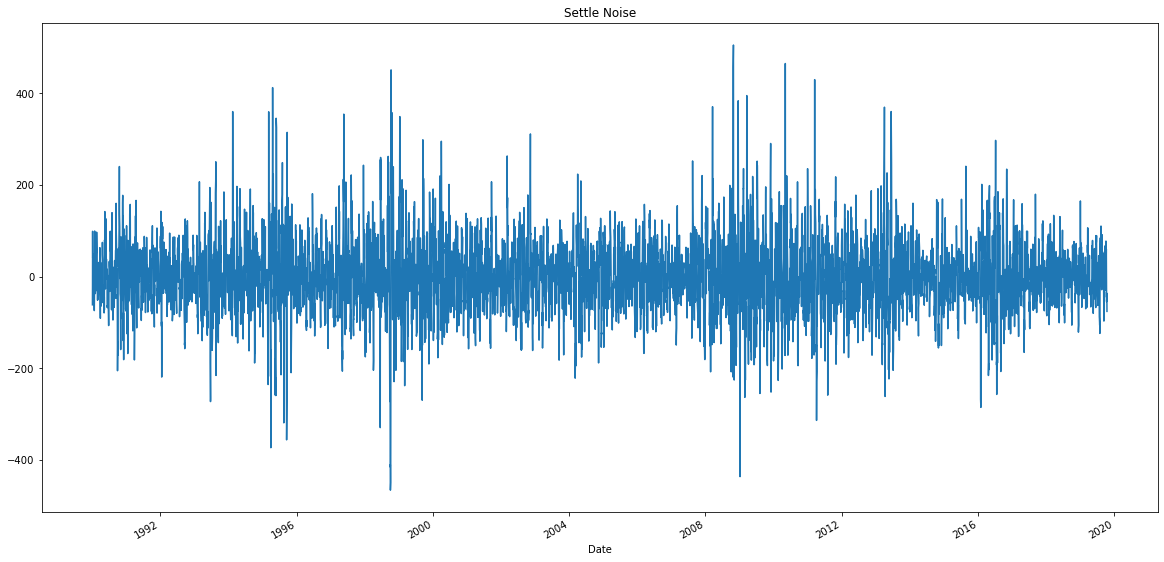

In [106]:
# Plot the Settle Noise
yen_settle['Noise'].plot(title='Settle Noise', figsize=(20,10))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [107]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [108]:
import statsmodels.api as sm

# I have to use the .arima.model import ARIMA instead of .arima_model import ARMA (doesn't work on my mac)
# No ARMA configuration seems to work
# Not .arima_model.ARMA, not .arima.model.ARMA, not with warnings
from statsmodels.tsa.arima.model import ARIMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARIMA(returns.values, order=(2,1,2))

# Fit the model and assign it to a variable called results
results = model.fit()

In [109]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7897.920
Date:                Sat, 05 Mar 2022   AIC                          15805.841
Time:                        19:02:30   BIC                          15840.463
Sample:                             0   HQIC                         15817.729
                               - 7514                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9984      0.061    -16.490      0.000      -1.117      -0.880
ar.L2         -0.0105      0.009     -1.197      0.231      -0.028       0.007
ma.L1         -0.0130      0.059     -0.220      0.826      -0.129       0.103
ma.L2         -0.9869      0.059    -16.635      0.000      -1.103      -0.871
sigma2         0.4787      0.005    105.165      0.000       0.470       0.488
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             17219.95
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

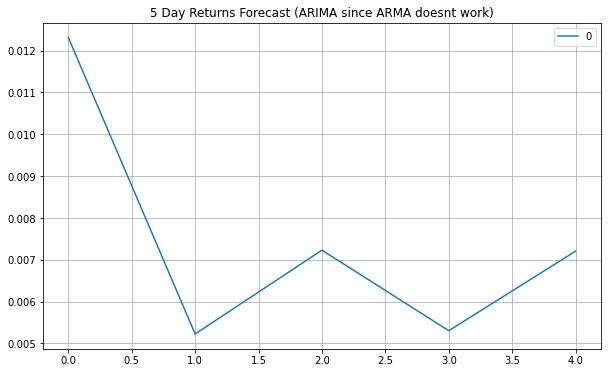

In [110]:
# Plot the 5 Day Returns Forecast
forecast = results.forecast(steps=5)
plot = pd.DataFrame(forecast).plot(figsize=(10,6), title='5 Day Returns Forecast (ARIMA since ARMA doesnt work)', grid=True)

# *** SINCE THIS IS AN ARIMA MODEL, IT IS NOT THE SAME AS WHAT THE ARMA MODEL WOULD OUTPUT***

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [111]:
from statsmodels.tsa.arima.model import ARIMA

# Estimate and ARIMA Model:
model = ARIMA(yen_futures['Settle'], order=(5,1,1))

# Fit the model
results_2 = model.fit()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [112]:
# Output model summary results:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7515
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.789
Date:                Sat, 05 Mar 2022   AIC                          83903.577
Time:                        19:02:31   BIC                          83952.049
Sample:                             0   HQIC                         83920.220
                               - 7515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0074      1.725     -0.004      0.997      -3.389       3.374
ar.L2         -0.0035      0.027     -0.128      0.898      -0.057       0.050
ar.L3         -0.0137      0.011     -1.197      0.231      -0.036       0.009
ar.L4         -0.0176      0.026     -0.674      0.501      -0.069       0.034
ar.L5         -0.0051      0.031     -0.161      0.872      -0.067       0.057
ma.L1         -0.0076      1.725     -0.004      0.996      -3.389       3.373
sigma2      4132.5390     33.382    123.796      0.000    4067.112    4197.966
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13716.71
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


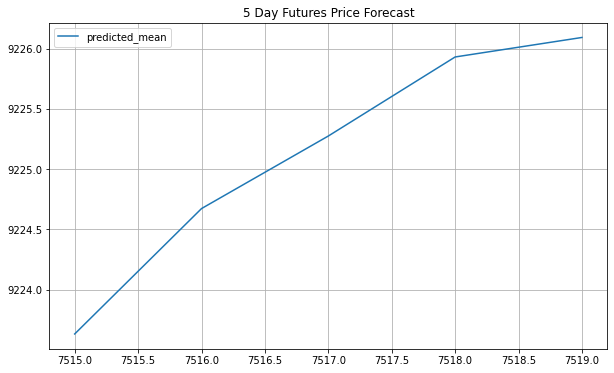

In [113]:
# Plot the 5 Day Price Forecast
forecast_2 = results_2.forecast(steps=5)
plot = pd.DataFrame(forecast_2).plot(figsize=(10,6), title='5 Day Futures Price Forecast', grid=True)

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [115]:
from arch import arch_model

In [116]:
# Estimate a GARCH model:
garch_model = arch_model(returns, mean='Zero', vol='GARCH', p=2, q=1)

# Fit the model
results_3 = garch_model.fit(disp='off')

In [117]:
# Summarize the model results
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Sat, Mar 05 2022   Df Residuals:                     7514
Time:                        19:04:44   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [118]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [120]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = results_3.forecast(start= last_day, horizon= forecast_horizon, reindex=True)
forecasts

In [121]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434032,7.475729,7.516851,7.55741,7.597418


In [122]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434032
h.2,7.475729
h.3,7.516851
h.4,7.557410
h.5,7.597418


<AxesSubplot:title={'center':'Final Forecast'}>

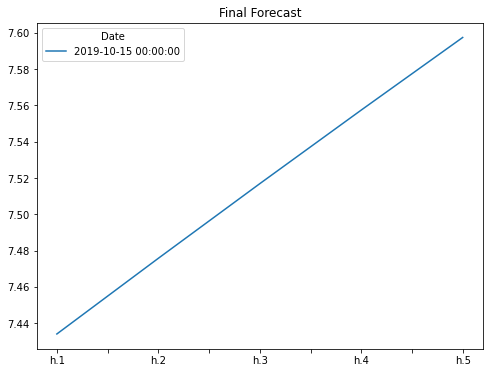

In [127]:
# Plot the final forecast
final.plot(figsize=(8,6), title='Final Forecast')

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

# Based on the models, I would not buy the yen now. While the price of the yen is looking to increase, as is the risk. The models above are mostly not good fits; the GARCH model is the best fit, however, there are only a few significant values. I would not feel confident using these models for trading.